In [87]:
import pandas as pd

# this crates a very simple dataset where a description maps to a price
df = pd.read_csv("https://raw.githubusercontent.com/john-zhang-uoft/hotel_price_prediction/main/src/data.csv")
df = df[["userReviews", "price"]]

df = df.rename(columns={"userReviews": "text", "price": "labels"}) # necessary for fine-tuning
df

,text,labels
0,A hidden gem in the Emerald City of Seattle ho...,6.212606
1,I liked it. Reasonable price for the location ...,5.826000
2,Exceptional The woman working at the front gav...,6.084499
3,definitely I will come back staff are great pe...,6.061457
4,"Super Seattle hotel The hotel was funky, well ...",5.937536
...,...,...
4414,it was a percect location for my trip. it was ...,5.062595
4415,good the housekeeping service do your room and...,5.446737
4416,"Very Good great location, clean and friendly s...",5.187386
4417,Exceptional Really close to the Universal park...,5.327876


In [88]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [89]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import Dataset

# fine-tuning implementation based on:
# https://predictivehacks.com/how-to-fine-tune-an-nlp-regression-model-with-transformers-and-huggingface/

# Create the dataset based on our pandas dataframe
dataset = Dataset.from_pandas(df, preserve_index=False)
dataset = dataset.train_test_split(test_size=0.25, seed=0)

# Tokenize the dataset
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Load the pre-trained model from huggingface (num_labels = 1 for regression)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

Map:   0%|          | 0/3314 [00:00<?, ? examples/s]

Map:   0%|          | 0/1105 [00:00<?, ? examples/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

In [90]:
from sklearn.metrics import mean_squared_error
from transformers import TrainingArguments, Trainer

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

training_args = TrainingArguments(output_dir="test_trainer",
                                  logging_strategy="epoch",
                                  evaluation_strategy="epoch",
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  num_train_epochs=5,
                                  save_total_limit = 2,
                                  save_strategy = 'no',
                                  load_best_model_at_end=False
                                  )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics
)

trainer.train()

predictions = trainer.predict(tokenized_datasets["test"])

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rmse
1,1.198800,0.357875,0.598226
2,0.176500,0.142906,0.378029
3,0.138200,0.139099,0.372959
4,0.104200,0.155306,0.394088
5,0.084800,0.129555,0.359937


0.6109906019558864


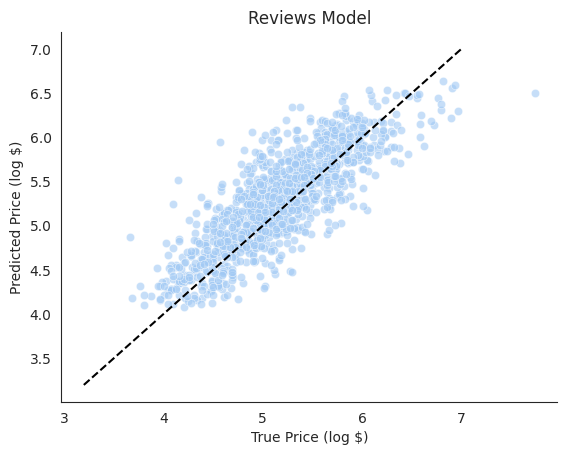

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

predicted =  predictions.predictions.reshape(-1)
y_test = np.array(tokenized_datasets["test"]["labels"])

# plot the data
sns.set_style("white")
sns.set_palette("pastel")
print(r2_score(y_test, predicted))
sns.scatterplot(x=y_test, y=predicted, alpha=0.6)
x_range = np.linspace(3.2, 7, 10)
sns.lineplot(x=x_range, y=x_range, color='k', ls="--")
plt.xlabel("True Price (log $)")
plt.ylabel("Predicted Price (log $)")
plt.title("Reviews Model")
sns.despine()
plt.savefig("reviews_model.png", dpi=200)
plt.show()

In [92]:
model.save_pretrained("model_reviews")
tokenizer.save_pretrained("tokenizer_reviews")

('tokenizer_reviews/tokenizer_config.json',
 'tokenizer_reviews/special_tokens_map.json',
 'tokenizer_reviews/vocab.txt',
 'tokenizer_reviews/added_tokens.json',
 'tokenizer_reviews/tokenizer.json')

In [93]:
new_df = pd.read_csv("https://raw.githubusercontent.com/john-zhang-uoft/hotel_price_prediction/main/data/final_data.csv")
new_df

,name,city,Width,Height,Brightness,Color,Dominate,description,stars,price,...,seattle,toronto,tucson,washington_dc,c1,c2,c3,d1,d2,d3
0,Sheraton Centre Toronto Hotel,toronto,1024,683,155.256676,[160.03191629 154.12408206 149.43024942],[200.57826 200.7613 203.15504],"Located in the center of downtown Toronto, thi...",0.991736,6.146329,...,0,1,0,0,160.031916,154.124082,149.430249,200.578260,200.761300,203.155040
1,Executive Hotel Cosmopolitan Toronto,toronto,1024,683,83.055545,[92.64822875 80.32992228 73.82429167],[19.295359 15.373721 14.762594],Executive Hotel Cosmopolitan Toronto is locate...,0.991736,5.786897,...,0,1,0,0,92.648229,80.329922,73.824292,19.295359,15.373721,14.762594
2,Bisha Hotel Toronto,toronto,1024,698,124.711664,[125.08205643 124.53883865 125.15122028],[170.05089 169.21521 166.77252],Located in the heart of downtown Toronto's Ent...,2.234641,6.202536,...,0,1,0,0,125.082056,124.538839,125.151220,170.050890,169.215210,166.772520
3,"Holiday Inn Toronto Downtown Centre, an IHG Hotel",toronto,1024,683,151.273481,[157.78680911 150.75462116 131.68814914],[183.58603 179.1546 161.714 ],This hotel is located next door to Maple Leaf ...,0.991736,5.652489,...,0,1,0,0,157.786809,150.754621,131.688149,183.586030,179.154600,161.714000
4,Delta Hotels by Marriott Toronto,toronto,1024,683,130.871141,[142.68008356 127.70386421 118.32489791],[110.95356 77.24888 60.295742],"Located in the heart of downtown Toronto, the ...",0.991736,6.194405,...,0,1,0,0,142.680084,127.703864,118.324898,110.953560,77.248880,60.295742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982,Cambria Hotel Washington D.C. Capitol Riverfront,washington_dc,1024,683,137.776383,[152.10232888 134.04020349 120.76507452],[119.40983 90.022766 70.04221 ],"Located in Washington, D.C., a 4-minute walk f...",0.991736,6.549651,...,0,0,0,1,152.102329,134.040203,120.765075,119.409830,90.022766,70.042210
2983,Glover Park Hotel Georgetown,washington_dc,1024,683,130.320680,[134.47323675 129.1918066 126.74156839],[174.98586 170.27669 169.48189],Glover Park Hotel Georgetown is 4 minutes' dri...,0.991736,5.283204,...,0,0,0,1,134.473237,129.191807,126.741568,174.985860,170.276690,169.481890
2984,Residence Inn Washington Capitol Hill/Navy Yard,washington_dc,1024,683,134.167210,[138.87619103 132.93041242 129.61814976],[44.07484 38.75437 35.979973],"Featuring free WiFi and a fitness center, Resi...",-0.251169,6.129050,...,0,0,0,1,138.876191,132.930412,129.618150,44.074840,38.754370,35.979973
2985,Washington Marriott Georgetown,washington_dc,1024,683,115.110339,[120.58370985 114.02776697 105.82554133],[95.89696 88.01665 77.69004],The Washington Marriott Georgetown is within 1...,0.991736,5.796058,...,0,0,0,1,120.583710,114.027767,105.825541,95.896960,88.016650,77.690040


In [94]:
import torch
from google.colab import drive

new_model = AutoModelForSequenceClassification.from_pretrained("model_reviews").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("tokenizer_reviews")

outputs = []
for j in range(new_df.shape[0]):
  inputs = tokenizer(new_df["userReviews"].tolist()[j], return_tensors="pt", padding="max_length", truncation=True)
  inputs = {k:v.to("cuda") for k, v in inputs.items()}
  with torch.no_grad():
    try:
      output = model(**inputs, output_hidden_states=True)
      outputs.append(output.hidden_states[-1][:, 0])
    except:
      print(j)

data = torch.cat(outputs, 0)

In [101]:
np_data = data.cpu().numpy()

In [106]:
features = pd.DataFrame(np_data)
features.to_csv("review_features.csv", index=False)